In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


#Dataset Prepration

In [13]:
!cp "/content/drive/MyDrive/vegetable-image-dataset.zip" "/content"

In [ ]:
!unzip *.zip && rm -rf *.zip

In [18]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [22]:
train_datagen = ImageDataGenerator(
    fill_mode='nearest', 
    horizontal_flip=True, 
    vertical_flip=True, 
    rescale=1./255,
    rotation_range=90,
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    brightness_range=None, 
    zoom_range=0.2
)
test_datagen = ImageDataGenerator(
    rescale=1./255
)
val_datagen = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow_from_directory(
    "/content/Vegetable Images/train",
    target_size=(96, 96),
    batch_size=32,
    class_mode="categorical"
)

test_generator = test_datagen.flow_from_directory(
    "/content/Vegetable Images/test",
    target_size=(96, 96),
    batch_size=32,
    class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
    "/content/Vegetable Images/validation",
    target_size=(96, 96),
    batch_size=32,
    class_mode="categorical"
)

Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


In [25]:
classnames = train_generator.class_indices

In [24]:
images, labels = next(train_generator)

In [33]:
label_map = {value:key for key,value in classnames.items()}
label_map

{0: 'Bean',
 1: 'Bitter_Gourd',
 2: 'Bottle_Gourd',
 3: 'Brinjal',
 4: 'Broccoli',
 5: 'Cabbage',
 6: 'Capsicum',
 7: 'Carrot',
 8: 'Cauliflower',
 9: 'Cucumber',
 10: 'Papaya',
 11: 'Potato',
 12: 'Pumpkin',
 13: 'Radish',
 14: 'Tomato'}

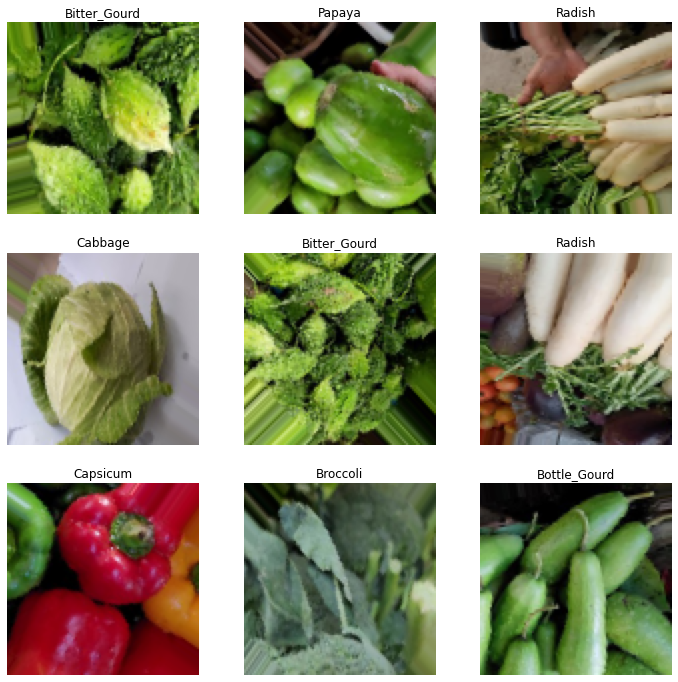

In [37]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 12))
for i in range(3*3):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(images[i])
  plt.title(label_map[np.argmax(labels[i])])
  plt.axis("off")

#Model

In [38]:
numclasses = len(label_map)
numclasses

15

In [39]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", input_shape=(96, 96, 3)),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

  tf.keras.layers.Dropout(rate=0.2),
  tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same"),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

  tf.keras.layers.Dropout(rate=0.2),
  tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same"),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

  tf.keras.layers.Dropout(rate=0.2),
  tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same"),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(units=512, activation="relu"),
  tf.keras.layers.Dropout(rate=0.1),
  tf.keras.layers.Dense(units=512, activation="relu"),
  tf.keras.layers.Dropout(rate=0.1),
  tf.keras.layers.Dense(numclasses, activation="softmax")
])

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 48, 48, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 64)        0

In [41]:
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=['accuracy'])

In [42]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(verbose=1),
    tf.keras.callbacks.ModelCheckpoint(
        'model.hdf5',
        monitor="val_loss",
        mode="min",
        save_best_only=True,
        verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                         min_delta=0,
                         patience=3,
                         verbose=1,
                         restore_best_weights=True),
    tf.keras.callbacks.TensorBoard(log_dir='logs')
]

In [43]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=test_generator,
    callbacks=callbacks
)

Epoch 1/50
469/469 [==============================] - ETA: 0s - loss: 1.4999 - accuracy: 0.4809
Epoch 1: val_loss improved from inf to 2.22014, saving model to model.hdf5
469/469 [==============================] - 80s 151ms/step - loss: 1.4999 - accuracy: 0.4809 - val_loss: 2.2201 - val_accuracy: 0.4273 - lr: 0.0010
Epoch 2/50
469/469 [==============================] - ETA: 0s - loss: 0.8732 - accuracy: 0.6967
Epoch 2: val_loss improved from 2.22014 to 1.31216, saving model to model.hdf5
469/469 [==============================] - 70s 149ms/step - loss: 0.8732 - accuracy: 0.6967 - val_loss: 1.3122 - val_accuracy: 0.6440 - lr: 0.0010
Epoch 3/50
469/469 [==============================] - ETA: 0s - loss: 0.6152 - accuracy: 0.7892
Epoch 3: val_loss improved from 1.31216 to 1.18567, saving model to model.hdf5
469/469 [==============================] - 69s 148ms/step - loss: 0.6152 - accuracy: 0.7892 - val_loss: 1.1857 - val_accuracy: 0.6373 - lr: 0.0010
Epoch 4/50
469/469 [==================

In [44]:
model.evaluate(val_generator)

94/94 [==============================] - 5s 57ms/step - loss: 0.2873 - accuracy: 0.9123


[0.28730231523513794, 0.9123333096504211]

In [45]:
images, labels = next(val_generator)

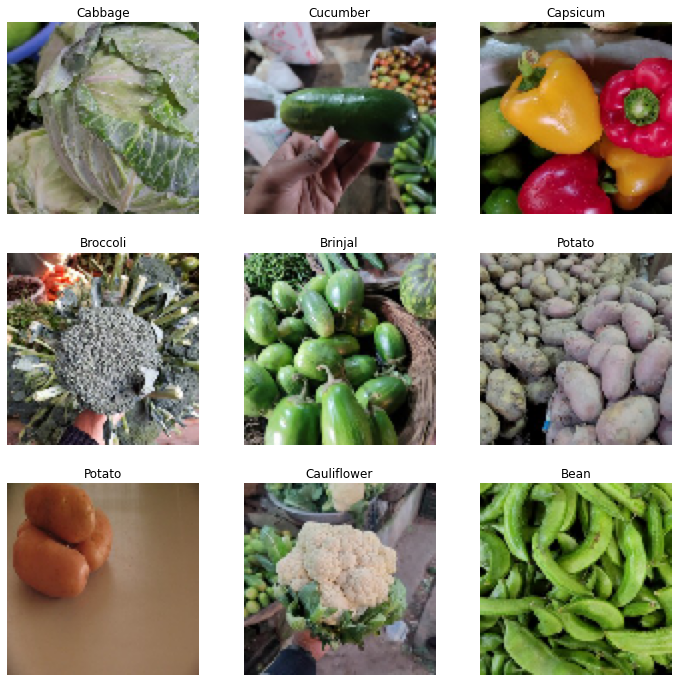

In [48]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 12))
for i in range(3*3):
  ax = plt.subplot(3, 3, i + 1)
  pred = model.predict(tf.expand_dims(images[i], 0))
  plt.imshow(images[i])
  # plt.title(label_map[np.argmax(labels[i])])
  plt.title(label_map[np.argmax(pred)])
  plt.axis("off")

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

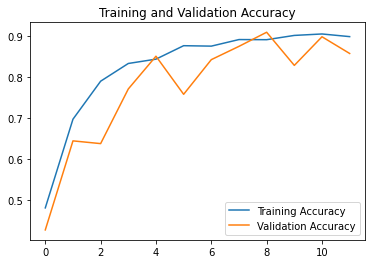

In [50]:
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

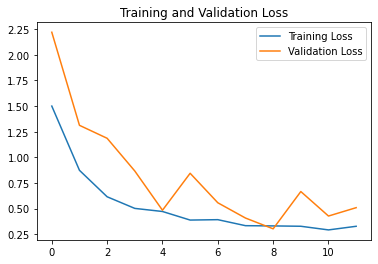

In [51]:
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()